## Assignment A5: Signal Representation

### David Courtney 3643806

***

In [1]:
using BenchmarkTools, FFTW, LinearAlgebra, Plots, Printf

# 1a
function plot_fourier_basis(N, k_values)
    theta = range(0, stop=2π, length=100)

    for k in k_values
        n = 0:N-1
        w_k_n = exp.(1im * 2π * k .* n / N)

        p = plot(cos.(theta), sin.(theta), linestyle=:dot, label="Unit circle",
                 aspect_ratio=:equal, xlims=(-1.1, 1.1), ylims=(-1.1, 1.1),
                 xlabel="Real", ylabel="Imaginary", title="Fourier Basis for k=$k", legend=:outertopright)

        scatter!(real(w_k_n), imag(w_k_n), color=:red, label="w_k[n] for k=$k")
        display(p)
    end
end

# 1b
function w(n, k, N)
    return exp(2π * 1im * k * n / N)
end

# 1b
function plotw(k, N)
    n = 0:N-1
    w_values = [w(ni, k, N) for ni in n]

    p1 = scatter(n, real.(w_values), label="Real Part", marker=:circle)
    plot!(n, real.(w_values), line=:stem, label=false)
    hline!(p1, [0], linecolor=:black, linestyle=:dash, label=false)

    p2 = scatter(n, imag.(w_values), label="Imaginary Part", marker=:circle, color=:red)
    plot!(n, imag.(w_values), line=:stem, label=false, color=:red)
    hline!(p2, [0], linecolor=:black, linestyle=:dash, label=false)

    plot(p1, p2, layout=(2, 1), size=(800, 400), legend=:outertopright)
end

# 1c
function inner_product(k, m, N)
    sum([w(n, k, N) * conj(w(n, m, N)) for n in 0:N-1])
end

# 1c
function format_complex(c::Complex)
    real_part = @sprintf("%6.2f", real(c))
    imag_part = @sprintf("%+6.2f", imag(c))
    return real_part * " " * imag_part * "im"
end

# 1c
function check_orthogonality(N)
    println("| k | m | Description           |   Inner Product |")
    println("|---|---|-----------------------|-----------------|")

    for k in 0:N-1
        for m in 0:N-1
            ip = inner_product(k, m, N)
            description = if k == m "w($k) with itself     " else "w($k) with w($m)       " end
            formatted_ip = format_complex(ip)
            println("| $k | $m | $description | $formatted_ip |")
        end
    end
end

# 2a
function fourier_matrix(N)
    [exp(-2im * π * k * n / N) for n = 0:(N-1), k = 0:(N-1)]
end

# 2a / 2b
function print_matrix(matrix)
    for i in 1:size(matrix, 1)
        for j in 1:size(matrix, 2)
            @printf("%6.2f %+6.2fj ", real(matrix[i,j]), imag(matrix[i,j]))
        end
        println()
    end
end

# 2c
function matrix_fft(x)
    N = length(x)
    F = fourier_matrix(N)
    return F * x
end

# 2c
function print_vector(v)
    for element in v
        @printf("%9.2f %+9.2fj  ", real(element), imag(element))
    end
    println()
end

# 2d
function benchmark_custom_fft(N)
    x = rand(N) + 1im * rand(N)
    F = fourier_matrix(N)
    t_custom = @elapsed F * x / sqrt(N)
    return t_custom
end

function benchmark_julias_fft(N)
    x = rand(N) + 1im * rand(N)
    t_julia = @elapsed fft(x)
    return t_julia
end

# 2e
function bandpass_noise(N, f_low, f_high)
    freq = 0:N-1
    amplitude_spectrum = zeros(N)
    amplitude_spectrum[f_low:f_high] .= 1.0
    phase_angles = rand(-π:π, N)
    spectrum = amplitude_spectrum .* exp.(1.0im * phase_angles)
    time_domain_signal = real(ifft(spectrum))
    return time_domain_signal
end

# 3
function fourier_basis(u, v, N)
    [exp(-2im * π * (u*i/N + v*j/N)) for i in 0:N-1, j in 0:N-1]
end

# 3
function dct_basis(u, v, N)
    [cos(π * u * (2*i + 1) / (2N)) * cos(π * v * (2*j + 1) / (2N)) for i in 0:N-1, j in 0:N-1]
end

# 3
function generate_basis_plots(N)
    # Pre-allocate arrays for the plot objects
    fourier_plots = []
    dct_plots = []

    for u in 0:N-1
        for v in 0:N-1
            # Fourier basis (real part)
            F_real = real(fourier_basis(u, v, N))
            push!(fourier_plots, heatmap(F_real, colorbar = false, axis = false))

            # DCT basis
            C = dct_basis(u, v, N)
            push!(dct_plots, heatmap(C, colorbar = false, axis = false))
        end
    end

    return fourier_plots, dct_plots
end

generate_basis_plots (generic function with 1 method)


### 1. Basis functions of the discrete Fourier transform

#### 1a. Visualizing the Complex Representation of a Fourier Basis

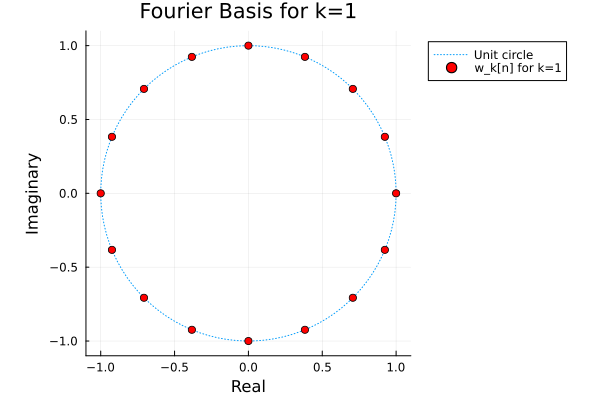

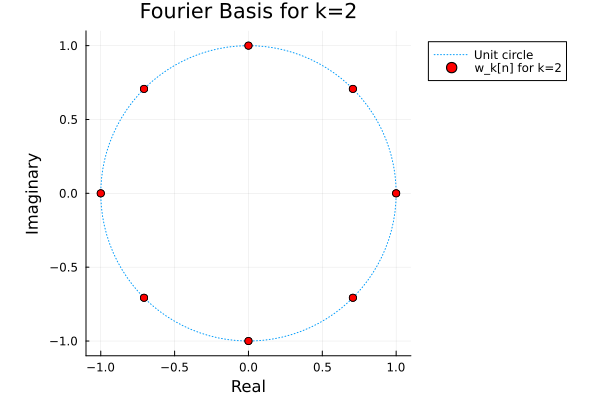

In [2]:
plot_fourier_basis(16, [1, 2])

When you plot the discrete Fourier transform (DFT) basis functions for different values of $k$, you visualize how these basis functions represent different frequency components of signals.

### For $k = 1$
- The plot shows the complex exponential $\exp(j2\pi \frac{1}{N} n)$ for $n = 0, \ldots, N-1$.
- This represents the lowest non-zero frequency in the DFT, corresponding to one complete cycle of a sine wave (imaginary part) and a cosine wave (real part) across the $N$ samples.
- On the unit circle, this traces out a single revolution. The points are spaced evenly around the circle, indicating that over the length of the signal, the wave completes exactly one oscillation.

### For $k = 2$
- The plot for $k = 2$ shows $\exp(j2\pi \frac{2}{N} n)$.
- This corresponds to the second-lowest frequency, which completes two full cycles within the same number of samples $N$.
- The points now trace out two complete revolutions around the unit circle. This faster wrapping around the circle reflects the higher frequency: the basis function oscillates twice as fast as for $k = 1$.

### General Observations
- In these plots, the real part (x-axis) of the complex exponential represents the cosine component, while the imaginary part (y-axis) represents the sine component.
- As $k$ increases, the number of times the points wrap around the unit circle within the $N$ samples increases, representing higher frequency components in the signal.
- These visualizations capture the essence of Fourier analysis: decomposing a signal into a sum of sinusoids of different frequencies. Each sinusoid corresponds to a point moving around the unit circle at a speed proportional to its frequency.
- The orthogonality and completeness of these basis functions mean that you can reconstruct the original signal perfectly from its DFT, given all the $N$ frequency components.

These plots are fundamental in understanding the frequency domain representation of signals, illustrating how each component $k$ in the DFT represents a specific frequency in the signal's spectrum.


The plots of the discrete Fourier transform (DFT) basis functions $\exp(j2\pi \frac{k}{N} n)$ for different values of $k$ illustrate how signals are represented in the frequency domain. Here's a detailed mathematical explanation:

### For $k = 1$
- The function $w_k[n] = \exp(j2\pi \frac{1}{N} n)$ is plotted for $n = 0, \ldots, N-1$.
- This function represents the fundamental frequency component, completing one full cycle around the unit circle in the complex plane over $N$ samples.
- Specifically, for $k = 1$:
  $$
  w_1[n] = \cos\left(2\pi\frac{1}{N}n\right) + j\sin\left(2\pi\frac{1}{N}n\right)
  $$
- Each point $w_1[n]$ for $n = 0, \ldots, N-1$ corresponds to a position on the unit circle, showing the real part (cosine) and imaginary part (sine) of the complex exponential function.

### For $k = 2$
- With $k = 2$, the function $w_k[n] = \exp(j2\pi \frac{2}{N} n)$ represents a higher frequency component, completing two full cycles around the unit circle within $N$ samples.
- Mathematically, for $k = 2$:
  $$
  w_2[n] = \cos\left(2\pi\frac{2}{N}n\right) + j\sin\left(2\pi\frac{2}{N}n\right)
  $$
- Here, $w_2[n]$ makes twice as many revolutions around the unit circle as $w_1[n]$, reflecting its higher frequency.

### General Mathematical Principles
- The DFT basis functions are complex exponentials representing sinusoidal waves at discrete frequencies.
- The frequency $\frac{k}{N}$ in $w_k[n] = \exp(j2\pi \frac{k}{N} n)$ dictates the number of cycles the function completes in a period of $N$ points.
- As $k$ increases, the frequency of the basis function increases, resulting in more revolutions around the unit circle within the $N$ sample points.
- These basis functions are orthogonal, ensuring distinct frequency components remain separate, which is essential for the Fourier transform's invertibility.

In summary, the plots of $w_k[n]$ on the complex plane visually represent the frequency components of a signal, with each $k$ indicating a distinct frequency. The full set of $N$ basis functions spans the signal space of length $N$, allowing for complete signal decomposition and reconstruction in the frequency domain.


#### 1b. Visualizing the basis functions

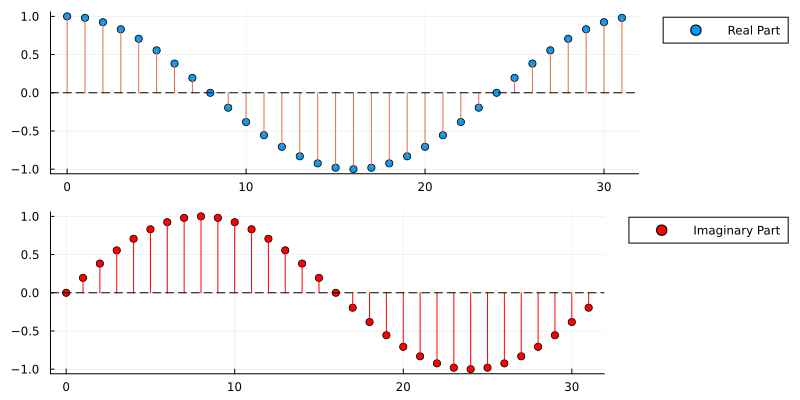

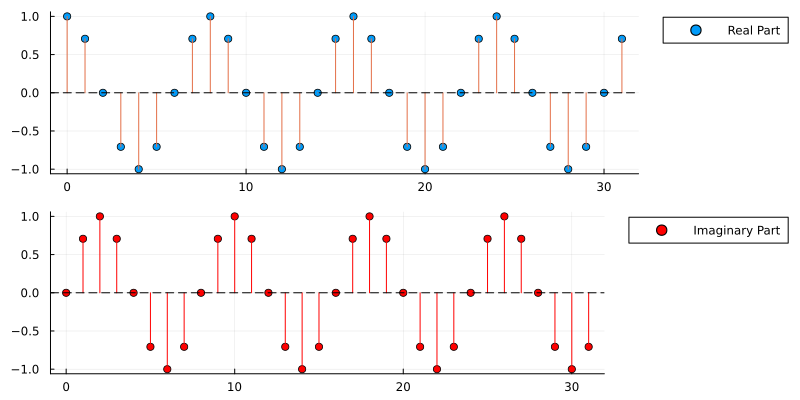

In [3]:
N = 32
display(plotw(1, N))
display(plotw(N ÷ 8, N))

#### 1c. Orthogonality

In [4]:
check_orthogonality(4)

| k | m | Description           |   Inner Product |
|---|---|-----------------------|-----------------|
| 0 | 0 | w(0) with itself      |   4.00  +0.00im |
| 0 | 1 | w(0) with w(1)        |  -0.00  -0.00im |
| 0 | 2 | w(0) with w(2)        |   0.00  -0.00im |
| 0 | 3 | w(0) with w(3)        |   0.00  -0.00im |
| 1 | 0 | w(1) with w(0)        |  -0.00  +0.00im |
| 1 | 1 | w(1) with itself      |   4.00  +0.00im |
| 1 | 2 | w(1) with w(2)        |  -0.00  -0.00im |
| 1 | 3 | w(1) with w(3)        |   0.00  -0.00im |
| 2 | 0 | w(2) with w(0)        |   0.00  +0.00im |
| 2 | 1 | w(2) with w(1)        |  -0.00  +0.00im |
| 2 | 2 | w(2) with itself      |   4.00  +0.00im |
| 2 | 3 | w(2) with w(3)        |  -0.00  -0.00im |
| 3 | 0 | w(3) with w(0)        |   0.00  +0.00im |
| 3 | 1 | w(3) with w(1)        |   0.00  +0.00im |
| 3 | 2 | w(3) with w(2)        |  -0.00  +0.00im |
| 3 | 3 | w(3) with itself      |   4.00  +0.00im |


The output of the `check_orthogonality` function provides empirical evidence for the orthogonality and non-orthonormality of the DFT basis vectors. Here’s how to interpret the results:

### Orthogonality
Orthogonality is demonstrated when the inner product of two different basis vectors is zero (or close to zero, considering numerical precision). In the table:

- The entries where $k \neq m$ (such as $w(0)$ with $w(1)$, $w(0)$ with $w(2)$, etc.) have inner product values close to $0.00 + 0.00i$, indicating these vectors are orthogonal. This behavior is expected for DFT basis vectors, as each represents a distinct frequency component and should be orthogonal to the others.

### Non-Orthonormality
Orthonormality would require that the inner product of each basis vector with itself equals 1. However, in the table:

- The entries where $k = m$ (such as $w(0)$ with itself, $w(1)$ with itself) have inner product values of $4.00 + 0.00i$. Given that your signal length $N$ is $4$, these results are equal to $N$, showing that while the vectors are normalized to $N$ rather than $1$, they are orthogonal but not orthonormal.

In summary, the table empirically shows that the DFT basis vectors are orthogonal to each other, as their inner products are zero (or nearly zero) for $k \neq m$. However, they are not orthonormal since the inner product of each vector with itself is equal to the length of the vector ($N$), not $1$. This distinction is crucial in signal processing for understanding how the DFT decomposes a signal into its frequency components and formulating the forward and inverse DFT calculations.


### 2. Fourier analysis in matrix-vector form

#### 2a.  Constructing the basis matrix

In [5]:
N = 10
F = fourier_matrix(N)
print_matrix(F)

  1.00  -0.00j   1.00  -0.00j   1.00  -0.00j   1.00  -0.00j   1.00  -0.00j   1.00  -0.00j   1.00  -0.00j   1.00  -0.00j   1.00  -0.00j   1.00  -0.00j 
  1.00  -0.00j   0.81  -0.59j   0.31  -0.95j  -0.31  -0.95j  -0.81  -0.59j  -1.00  -0.00j  -0.81  +0.59j  -0.31  +0.95j   0.31  +0.95j   0.81  +0.59j 
  1.00  -0.00j   0.31  -0.95j  -0.81  -0.59j  -0.81  +0.59j   0.31  +0.95j   1.00  +0.00j   0.31  -0.95j  -0.81  -0.59j  -0.81  +0.59j   0.31  +0.95j 
  1.00  -0.00j  -0.31  -0.95j  -0.81  +0.59j   0.81  +0.59j   0.31  -0.95j  -1.00  -0.00j   0.31  +0.95j   0.81  -0.59j  -0.81  -0.59j  -0.31  +0.95j 
  1.00  -0.00j  -0.81  -0.59j   0.31  +0.95j   0.31  -0.95j  -0.81  +0.59j   1.00  +0.00j  -0.81  -0.59j   0.31  +0.95j   0.31  -0.95j  -0.81  +0.59j 
  1.00  -0.00j  -1.00  -0.00j   1.00  +0.00j  -1.00  -0.00j   1.00  +0.00j  -1.00  -0.00j   1.00  +0.00j  -1.00  -0.00j   1.00  +0.00j  -1.00  -0.00j 
  1.00  -0.00j  -0.81  +0.59j   0.31  -0.95j   0.31  +0.95j  -0.81  -0.59j   1.00  +0.00j  -0.

#### 2b. Fourier matrix properties

In [6]:
N = 10
identity_matrix = Matrix{Complex{Float64}}(I, N, N)

println("Scaled Identity Matrix:")
print_matrix(identity_matrix)

Scaled Identity Matrix:
  1.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j 
  0.00  +0.00j   1.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j 
  0.00  +0.00j   0.00  +0.00j   1.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j 
  0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   1.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j 
  0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   1.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j 
  0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   1.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j 
  0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0.00j   0.00  +0

#### 2c. Comparing to the standard `fft` function.

In [7]:
N = 10
x = rand(N) + 1im * rand(N)

matrix_fft_result = matrix_fft(x)
fft_result = fft(x)

comparison = norm(matrix_fft_result - fft_result) < 1e-10

print_vector(fft_result)
print_vector(matrix_fft_result)

println("")
println("Numerically identical? ", comparison)

# Calculate the absolute difference
difference = abs.(matrix_fft_result - fft_result)

max_diff = maximum(difference)

println("Maximum difference: ", max_diff)


     5.86     +4.05j       0.78     +0.13j       0.94     +0.85j       0.10     -1.08j      -0.66     -0.99j       1.46     -0.65j      -2.31     -1.04j      -0.77     -0.89j       0.30     -0.28j       1.06     +0.64j  
     5.86     +4.05j       0.78     +0.13j       0.94     +0.85j       0.10     -1.08j      -0.66     -0.99j       1.46     -0.65j      -2.31     -1.04j      -0.77     -0.89j       0.30     -0.28j       1.06     +0.64j  

Numerically identical? true
Maximum difference: 6.408593517931132e-15


#### 2d. Benchmarking

In [8]:
N = 4096*10

# Benchmark custom FFT
t_custom = benchmark_custom_fft(N)

# Benchmark Julia's FFT
t_julia = benchmark_julias_fft(N)

# Calculate how many times slower the custom FFT is compared to Julia's FFT
ratio = t_custom / t_julia

println("Custom FFT (ms): ", t_custom * 1e3);
println("Julia's FFT (ms): ", t_julia * 1e3);
println("");
if ratio < 1
    println("Custom FFT is ", round(1 / ratio, digits=1), " times slower than Julia's FFT.")
else
    println("Julia's FFT is ", round(ratio, digits=1), " times faster than Custom FFT.")
end


Custom FFT (ms): 675.4569
Julia's FFT (ms): 1.9324999999999999

Julia's FFT is 349.5 times faster than Custom FFT.


#### 2e. Synthesizing bandpass noise

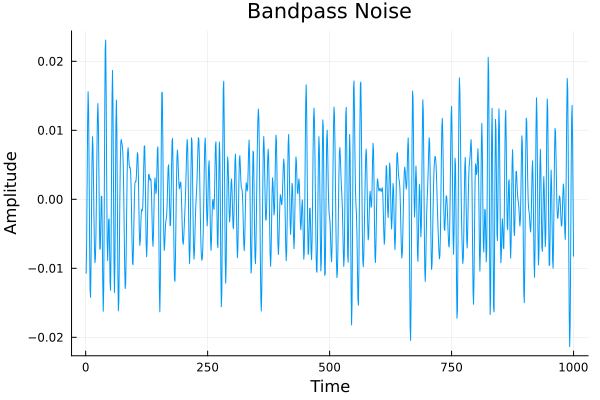

In [9]:
# Parameters
N = 1000         # Number of samples
f_low = 50       # Lower cutoff frequency (Hz)
f_high = 150     # Upper cutoff frequency (Hz)

# Synthesize bandpass noise
noise_signal = bandpass_noise(N, f_low, f_high)

# Plot the noise signal
plot(1:N, noise_signal, xlabel="Time", ylabel="Amplitude", title="Bandpass Noise", legend=false)


###  Explain what you did and show your examples

The code synthesizes bandpass noise using the inverse Fourier transform method. Here's a breakdown of the code and its functionality:

1. **Import Necessary Libraries**: The code begins by importing the required libraries, including `FFTW` for fast Fourier transform operations and `Plots` for visualization.

2. **Define `bandpass_noise` Function**: This function takes three parameters:
   - `N`: Number of samples in the synthesized noise signal.
   - `f_low`: Lower cutoff frequency of the bandpass filter.
   - `f_high`: Upper cutoff frequency of the bandpass filter.

3. **Frequency Domain Definition**: The function defines the frequency domain as a range from 0 to `N-1`.

4. **Amplitude Spectrum Definition**: It initializes an amplitude spectrum array with zeros and sets the amplitudes to 1.0 within the frequency range specified by `f_low` and `f_high`.

5. **Randomization of Phase Angles**: Random phase angles are assigned to each frequency component within the range.

6. **Combining Amplitude and Phase**: The amplitude spectrum and phase angles are combined to obtain complex-valued Fourier coefficients representing the noise spectrum.

7. **Inverse Fourier Transform**: The inverse Fourier transform is applied to convert the complex-valued coefficients back into the time domain, resulting in the synthesized bandpass noise signal.

8. **Plotting the Noise Signal**: The synthesized noise signal is plotted using the `Plots` package.


This code generates bandpass noise with a lower cutoff frequency of 50 Hz and an upper cutoff frequency of 150 Hz. It then plots the synthesized noise signal in the time domain.

By adjusting the parameters `N`, `f_low`, and `f_high`, you can control the length of the noise signal and the frequency range of the bandpass filter, allowing you to create different types of bandpass noise signals for various applications.

### 3. Transforms in 2D

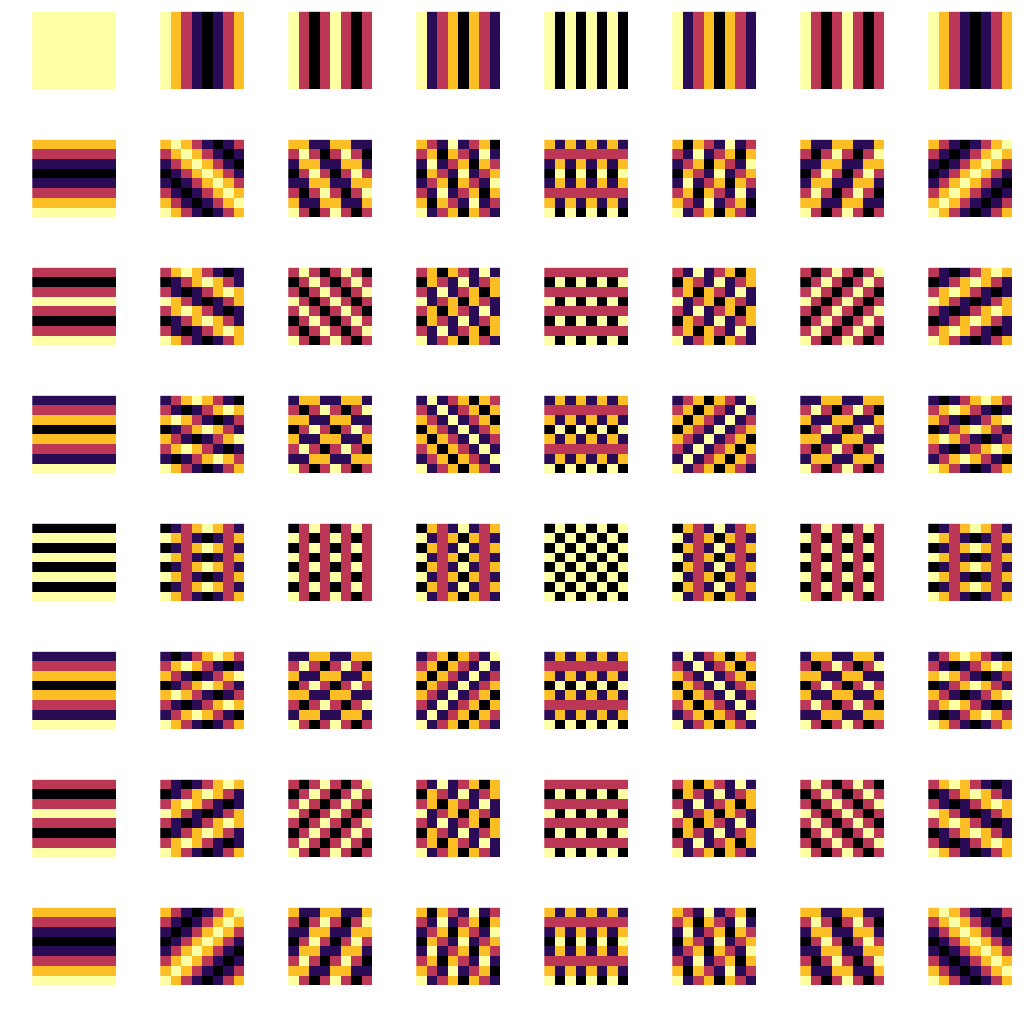

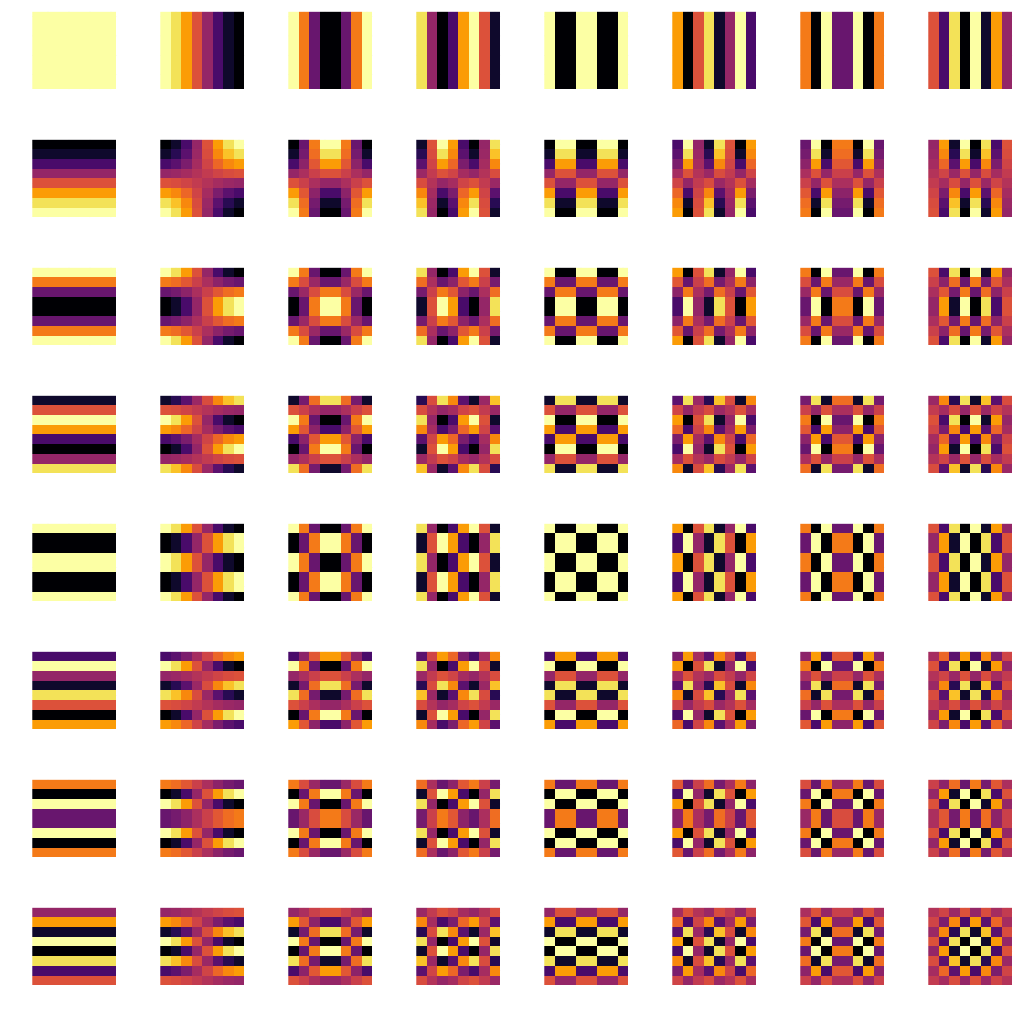

In [10]:
# Set the backend to GR
gr()

# Matrix size
N = 8

fourier_plots, dct_plots = generate_basis_plots(N)

# Combine plots into one figure
pixels = 1024
fourier_plot = plot(fourier_plots..., layout = (N, N), size = (pixels, pixels), axis = false)
dct_plot = plot(dct_plots..., layout = (N, N), size = (pixels, pixels), axis = false)

# Save the plots to files
savefig(fourier_plot, "fourier_basis.png")
savefig(dct_plot, "dct_basis.png")

# Display the plots
display(fourier_plot)
display(dct_plot)


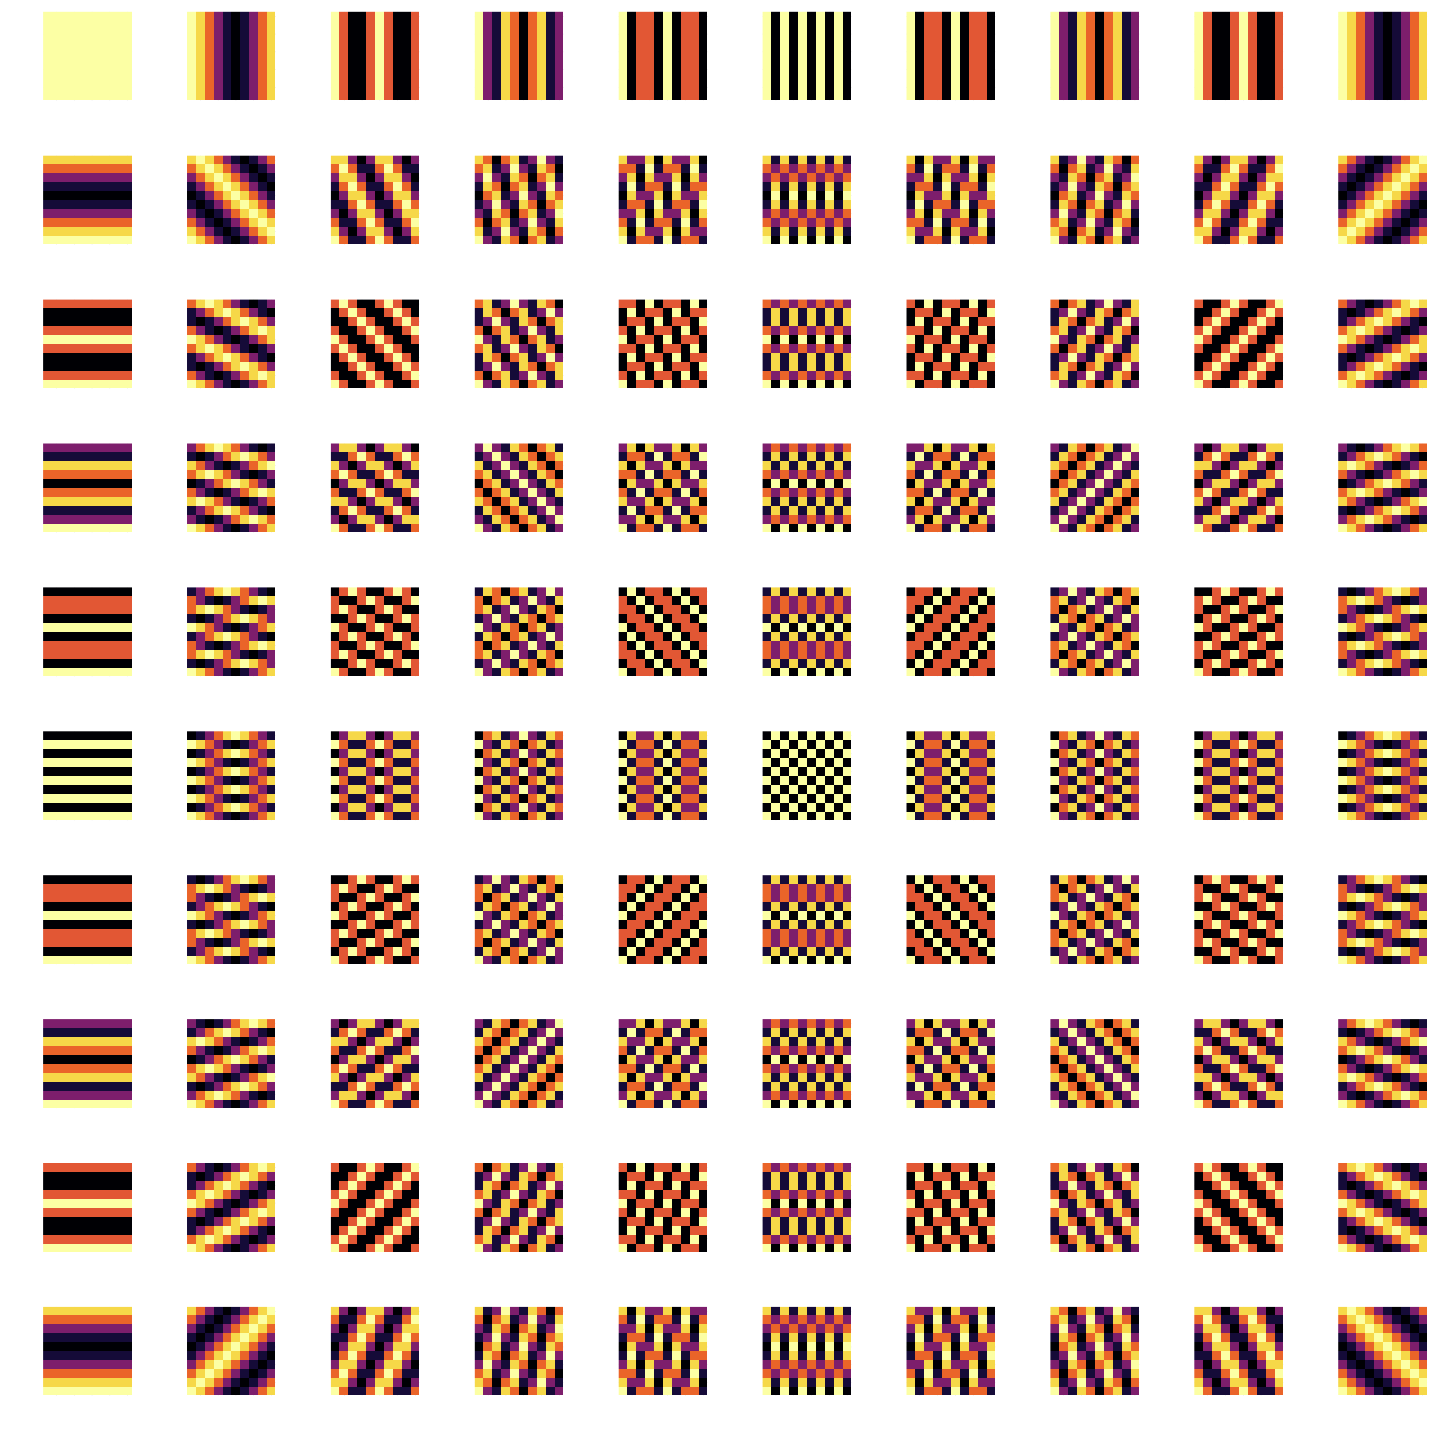

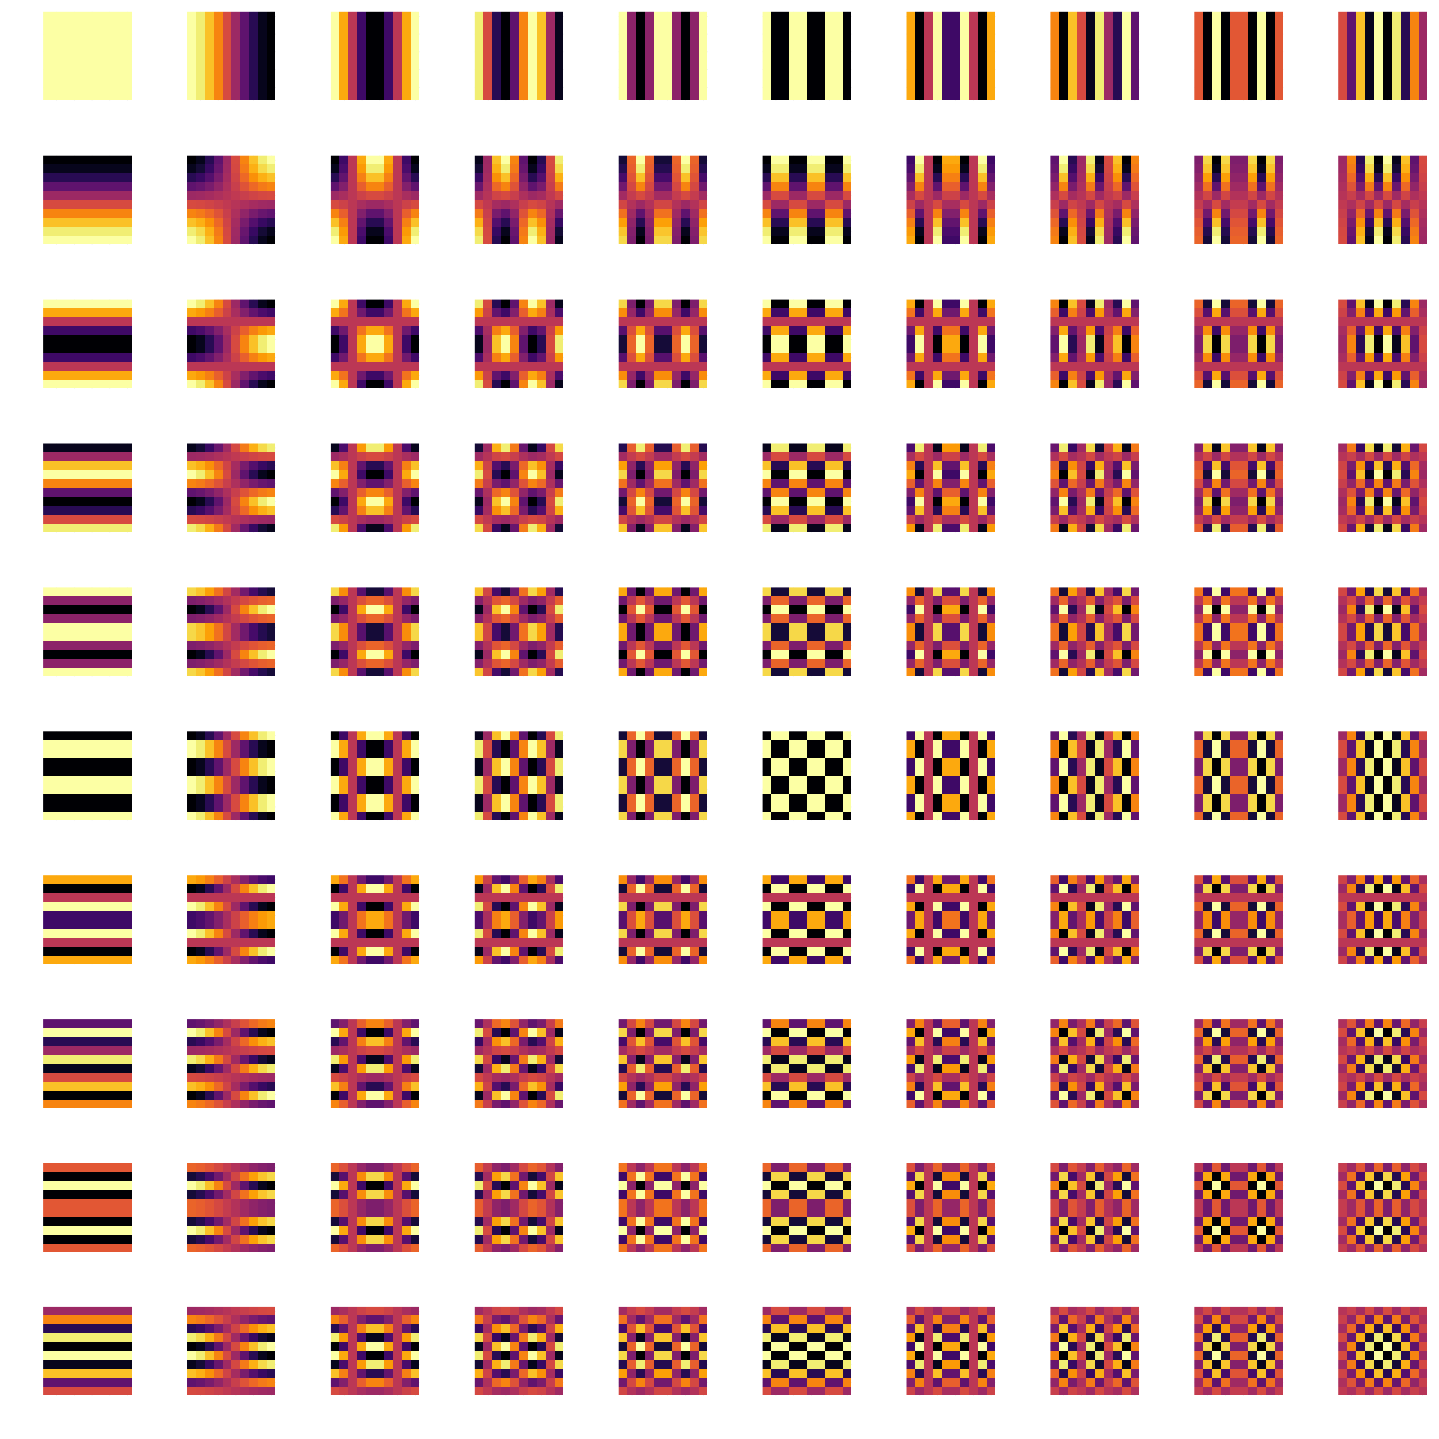

In [11]:
# Set the backend to GR
gr()

# Matrix size
N = 10

fourier_plots, dct_plots = generate_basis_plots(N)

# Combine plots into one figure
pixels = 1440
fourier_plot = plot(fourier_plots..., layout = (N, N), size = (pixels, pixels), axis = false)
dct_plot = plot(dct_plots..., layout = (N, N), size = (pixels, pixels), axis = false)

# Save the plots to files
savefig(fourier_plot, "fourier_basis.png")
savefig(dct_plot, "dct_basis.png")

# Display the plots
display(fourier_plot)
display(dct_plot)


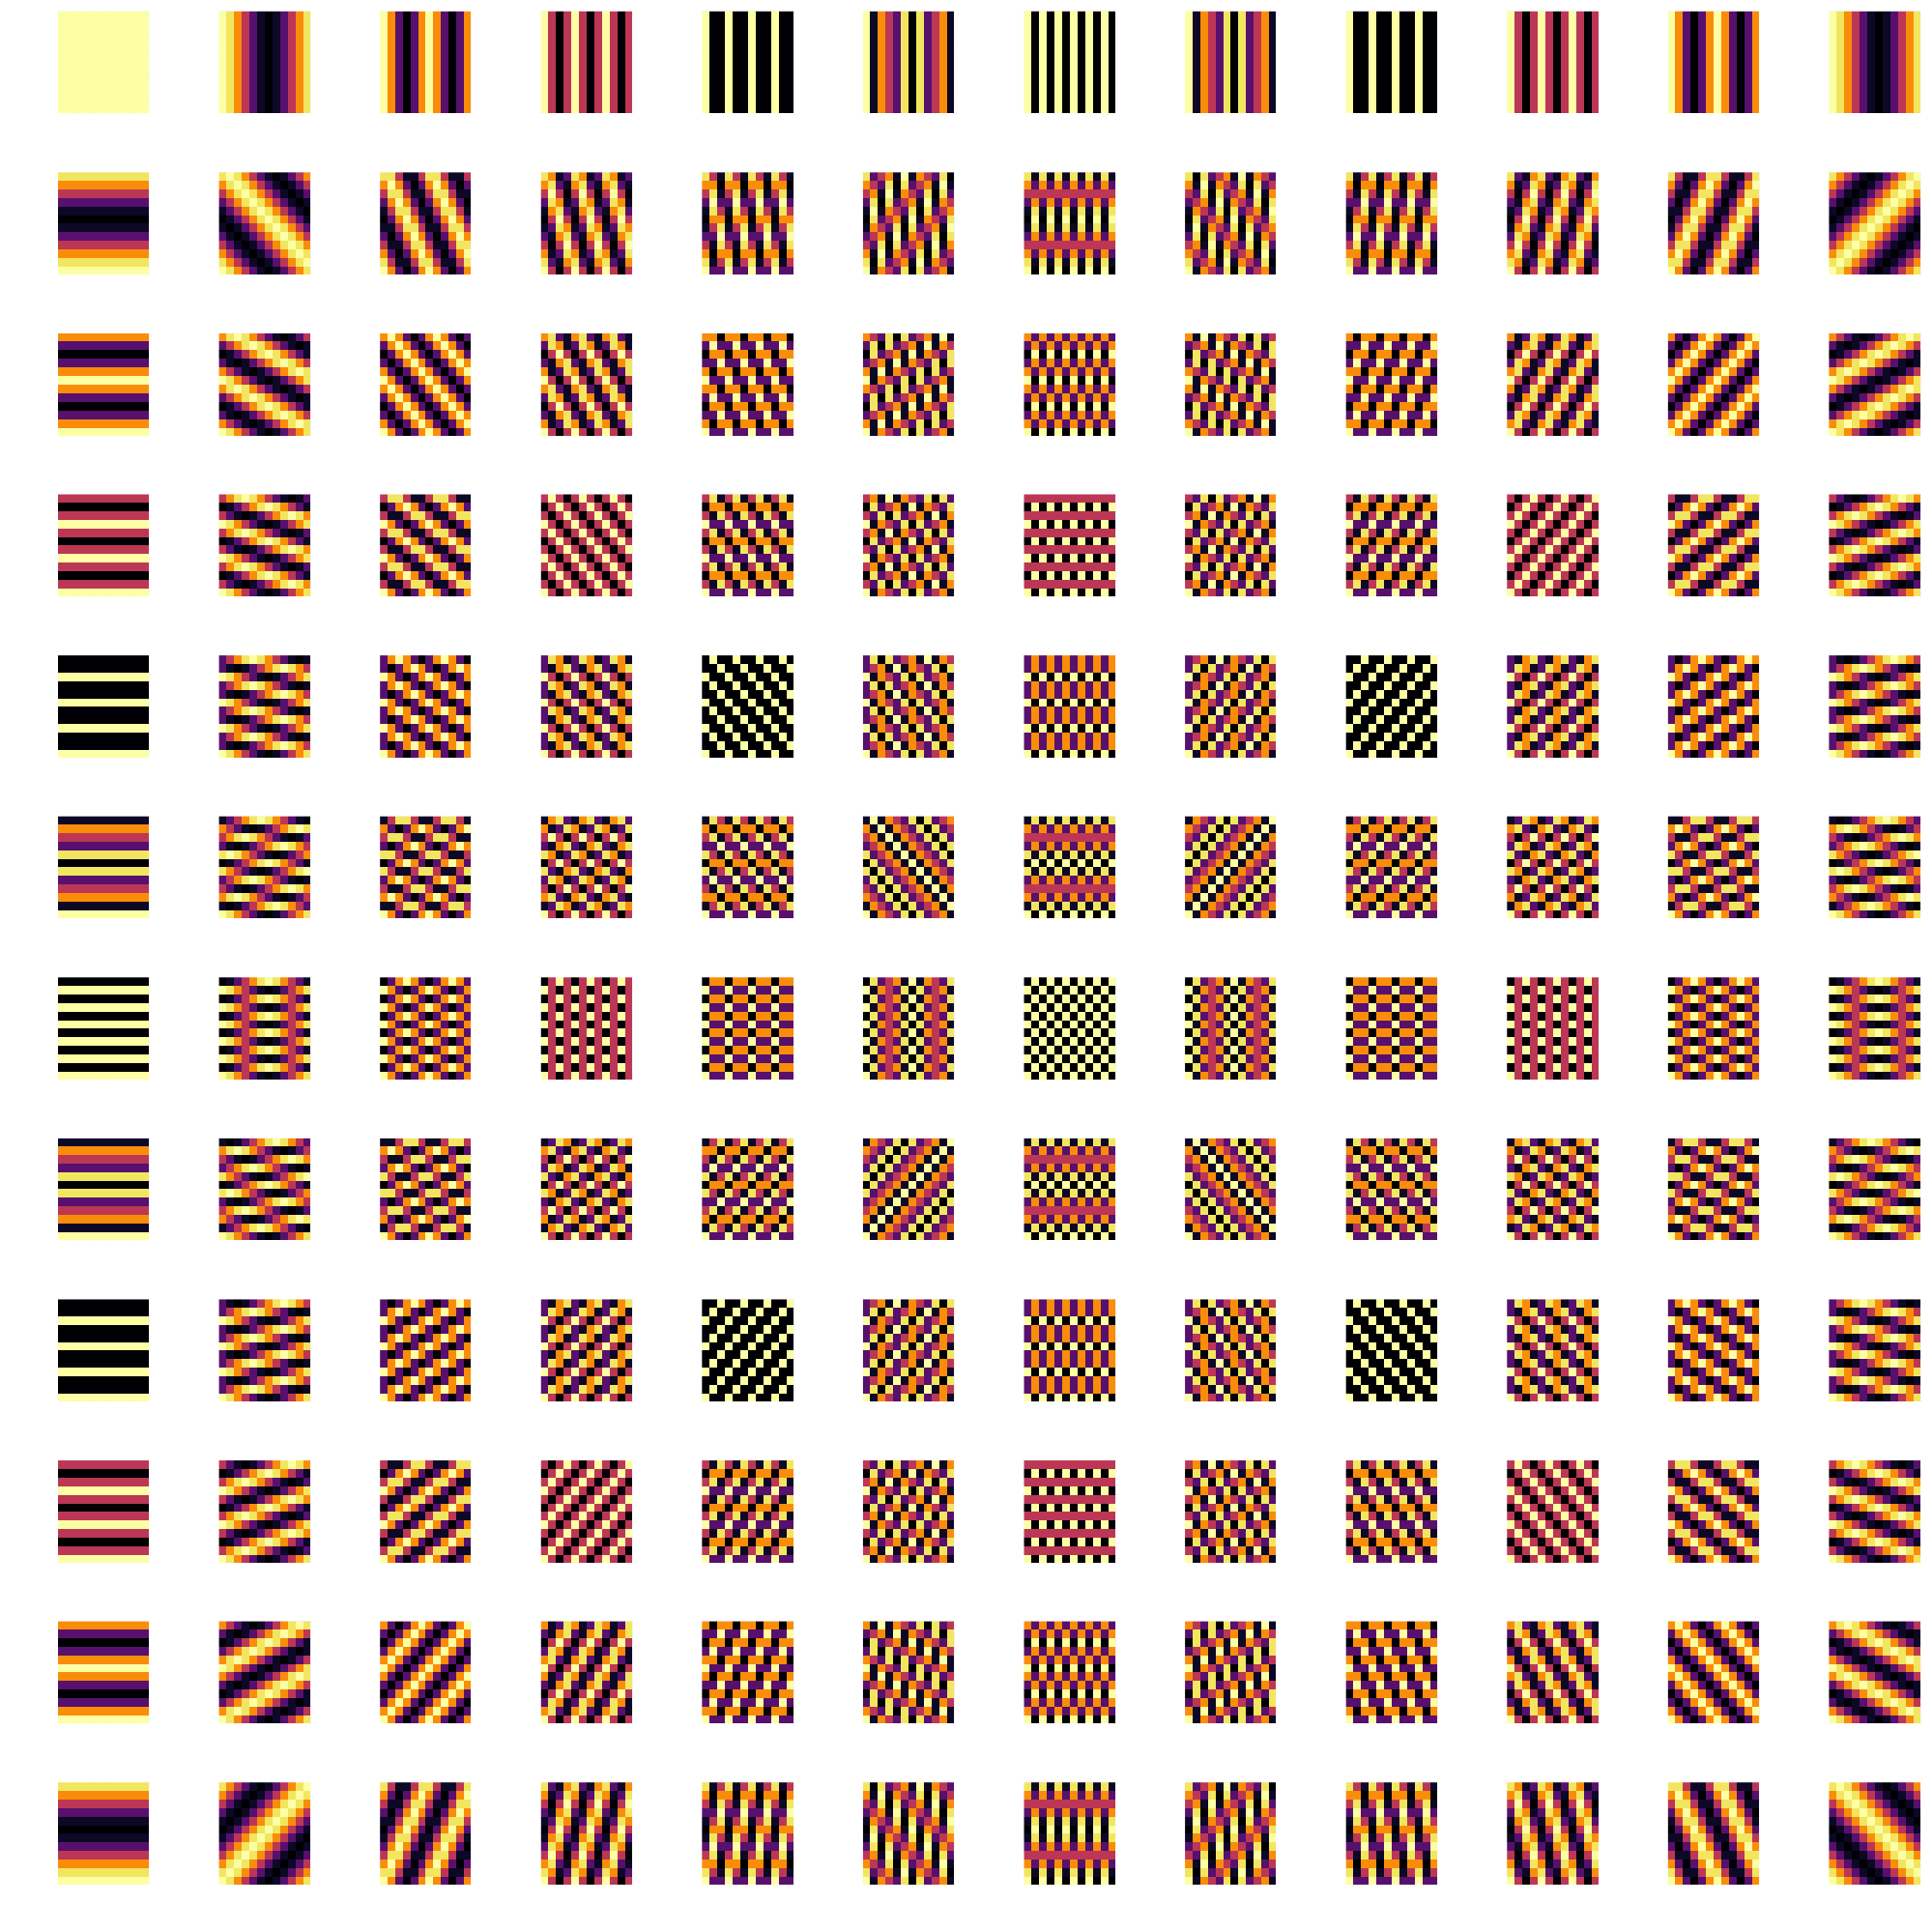

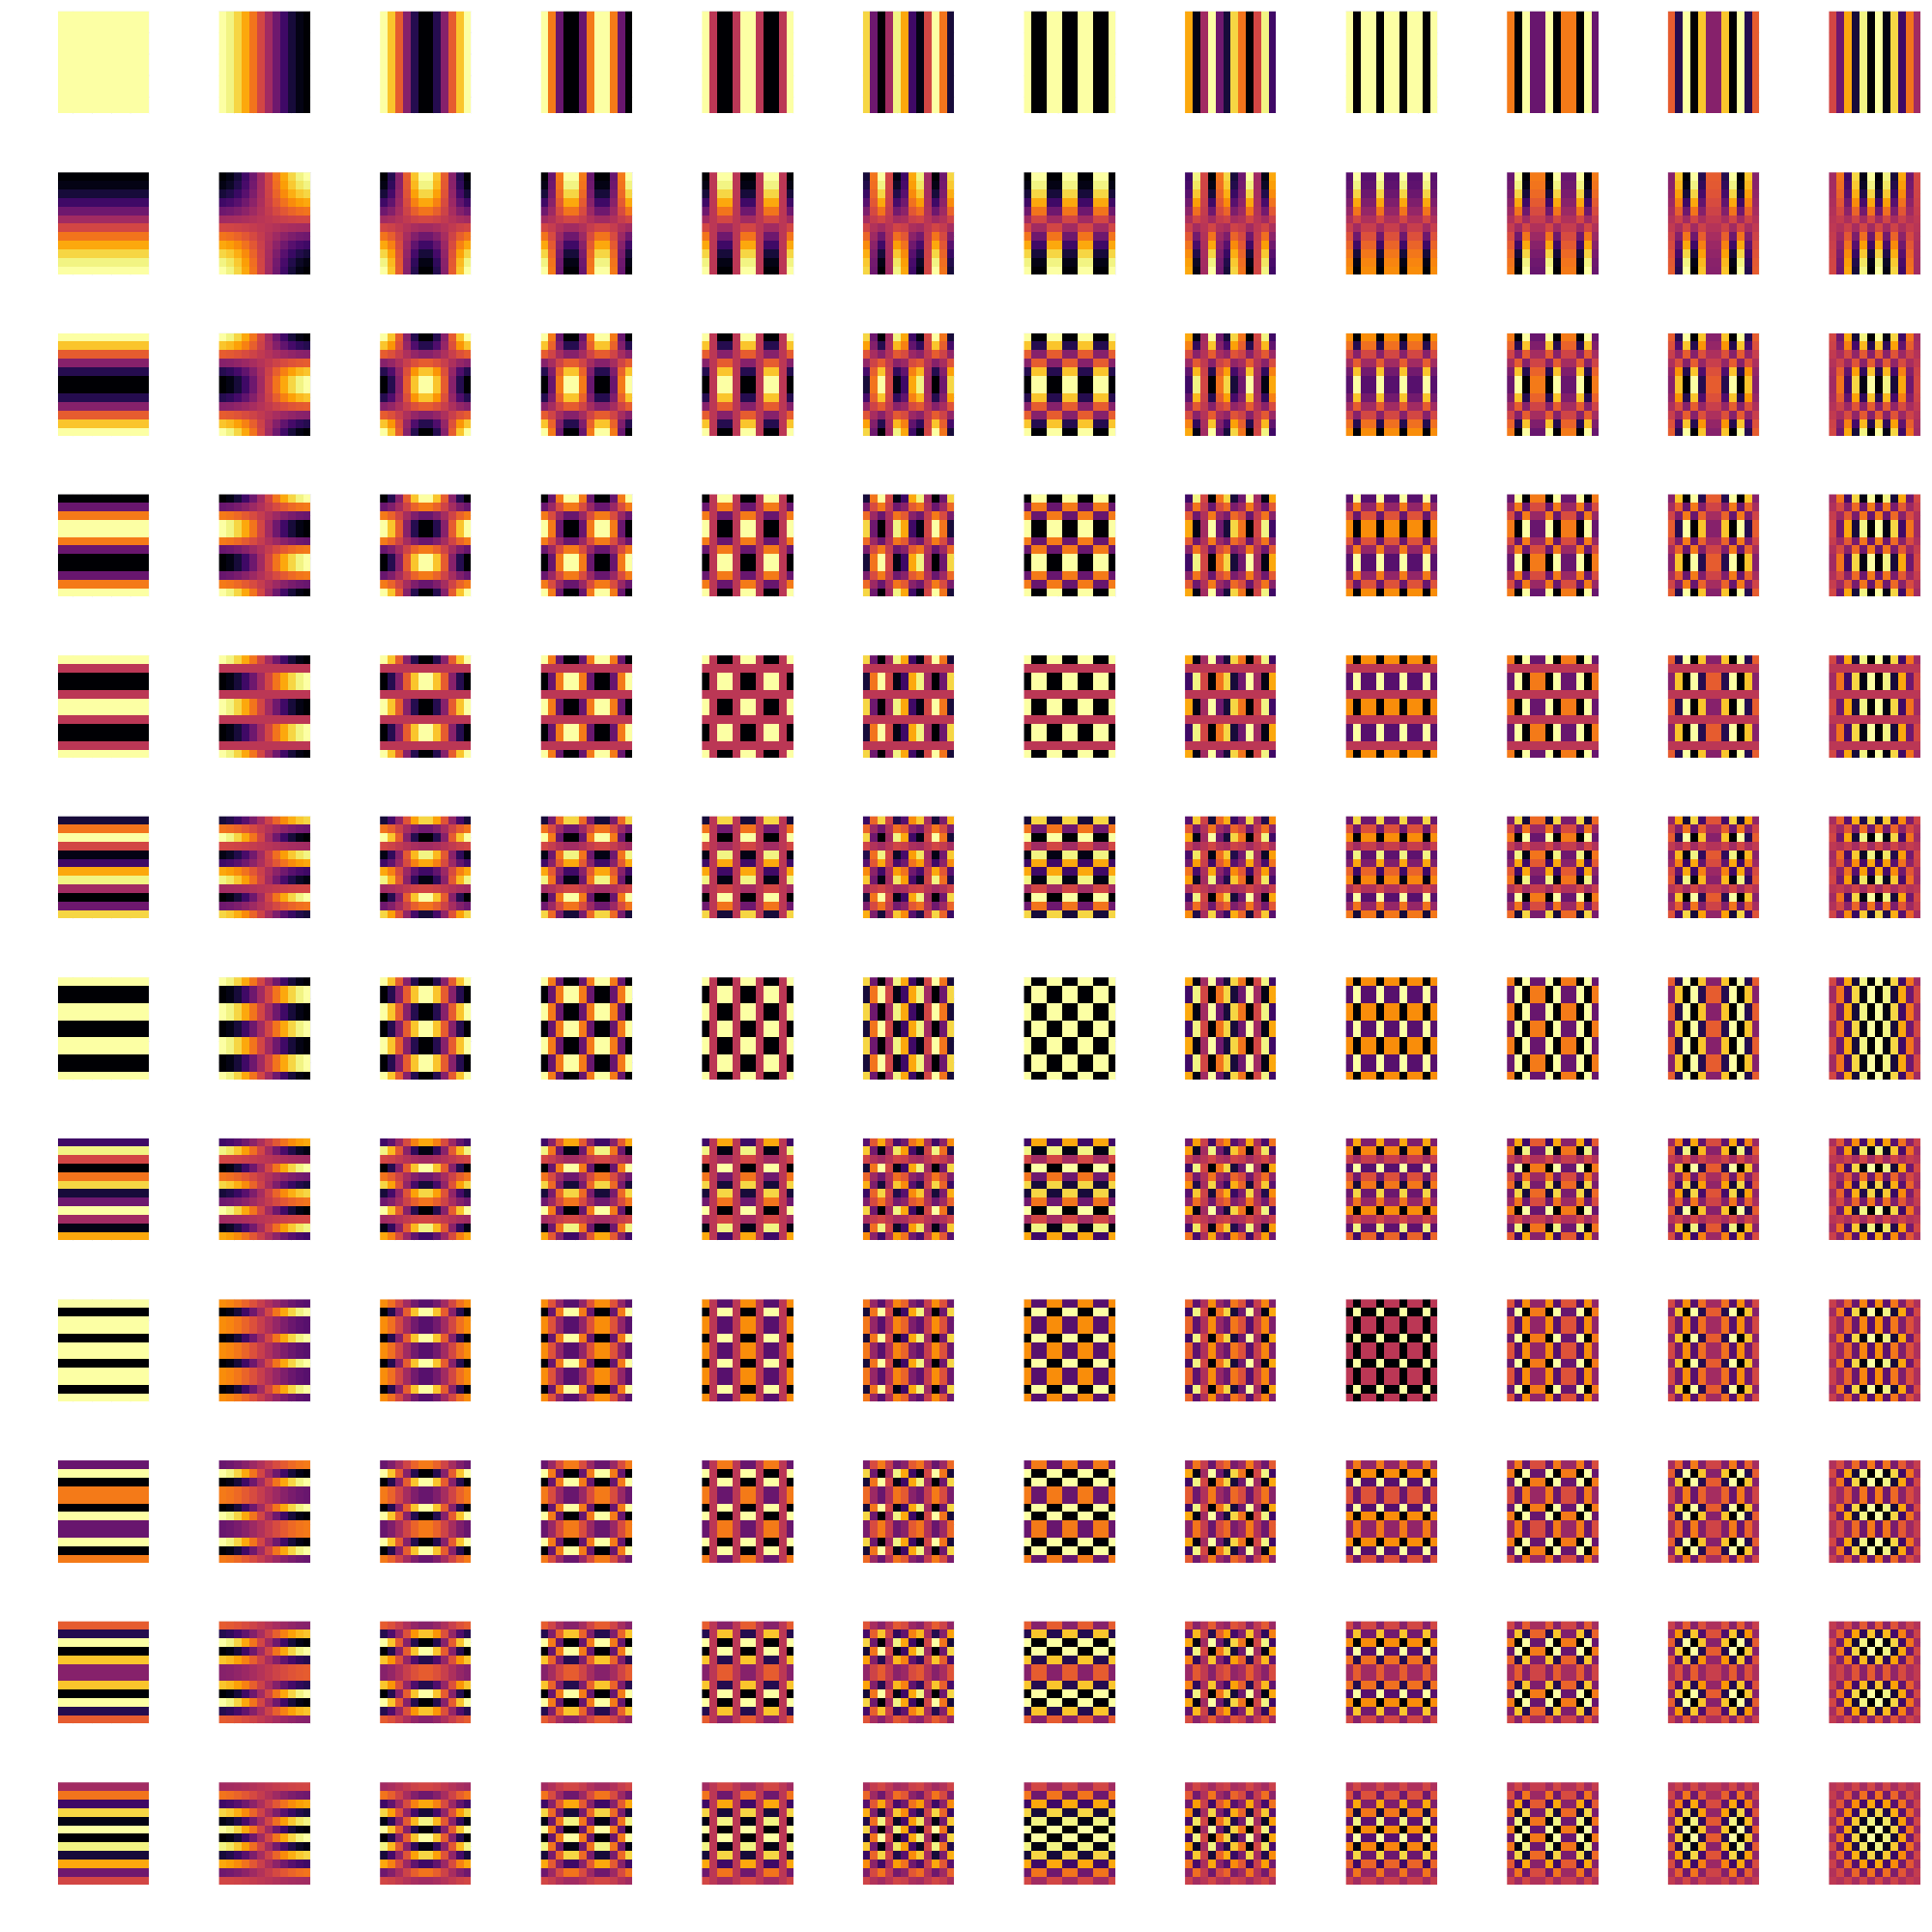

In [12]:
# Set the backend to GR
gr()

# Matrix size
N = 12

fourier_plots, dct_plots = generate_basis_plots(N)

# Combine plots into one figure
pixels = 2000
fourier_plot = plot(fourier_plots..., layout = (N, N), size = (pixels, pixels), axis = false)
dct_plot = plot(dct_plots..., layout = (N, N), size = (pixels, pixels), axis = false)

# Save the plots to files
savefig(fourier_plot, "fourier_basis.png")
savefig(dct_plot, "dct_basis.png")

# Display the plots
display(fourier_plot)
display(dct_plot)
